### OLS 회귀분석

In [3992]:
### 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

from scipy import stats
from scipy.stats import shapiro

import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro

### 환경설정
np.random.seed(4)


### 함수 정의
def preprocess_transaction_flag(df):
    df['transaction_flag'] = df['transaction_count'].apply(lambda x: 1 if x > 0 else 0)
    return df

def trim_date(df, start, end):
    ### df date 형식 맞춰주기
    df['date'] = df['date'].astype(str)
    if len(df['date'][0]) == 8:
        df['date'] = df['date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:])


    return df[(df['date']>=start) & (df['date']<=end)]

### 데이터 세팅

In [3993]:
# # test 데이터 읽기
# test_df = pd.read_csv("./data/test/test_df.csv")
# test_df.set_index('date', inplace=True)

# # price coin market cap으로
# price_df = pd.read_csv("./data/price/bitcoin_price_coin_market_cap.csv")
# price_df = price_df.set_index('date')


# test_df['close'] = price_df['close']
# test_df['open'] = price_df['open']
# test_df['high'] = price_df['high']
# test_df['low'] = price_df['low']
# test_df['volume'] = price_df['volume']

# test_df['returns'] = test_df['close'].pct_change()
# test_df['abs_returns'] = test_df['returns'].abs()

In [3994]:
### 학습용 데이터 읽기
test_df = pd.read_csv("./data/test/test_df.csv")
test_df.set_index('date', inplace=True)

### Realized Volatility 추가
test_df['rv'] = test_df['returns'].rolling(5).std()
test_df['rv'] = test_df['rv'].fillna(test_df['rv'].mean())

### 이벤트용 데이터 읽기
event_df = pd.read_csv("./data/event/bitcoin_event_details_sentiment.csv")
# event_df = pd.read_csv("./data/event/bitcoin_event_detail_no_explain.csv")
event_df.index = event_df['Date'].astype(str).apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:])

# target_event_receive_df = pd.read_csv("./data/target/screened_event_2_day_transactions_over_33_threshold_1000_receive.csv")
# target_event_receive_df = pd.read_csv("./data/target/screened_event_2_day_transactions_over_33_receive.csv")
target_event_receive_df = pd.read_csv("./data/target/event_2_day_transactions_over_136_threshold_1000_receive.csv")
# target_event_receive_df = pd.read_csv("./data/target/screened_event_2_day_transactions_over_25_threshold_1000_receive.csv")
# target_event_receive_df = pd.read_csv("./data/target/event_2_day_transactions_over_100_receive.csv")
# target_event_receive_df = pd.read_csv("./data/target/event_2_day_transactions_over_136_receive.csv")
target_event_receive_df = preprocess_transaction_flag(target_event_receive_df)
target_event_receive_df.columns = ['date', 'transaction_count', 'transaction_amount', 'transaction_flag']

target_event_receive_df = trim_date(target_event_receive_df, (test_df.index)[0], (test_df.index)[-1])


### Bitcoin Event Flag 추가 / 긍정, 부정, 애매 이벤트 필터링
# pos, neg, neu, all
event_sentiment = 'all'
if event_sentiment == 'all':
    pass
elif event_sentiment == 'pos':
    event_df = event_df[event_df['classification']==1]
elif event_sentiment == 'neg':
    event_df = event_df[event_df['classification']==0]
elif event_sentiment == 'neu':
    event_df = event_df[event_df['classification']==2]
event_df['classification'] = 1
event_df = event_df['classification']
event_df = event_df[~event_df.index.duplicated(keep='first')]

test_df['event_flag'] = event_df
test_df['event_flag'] = test_df['event_flag'].fillna(0)
event_flag_copy = test_df['event_flag'].values

### 분석 데이터 선택
target_df = target_event_receive_df.copy().set_index('date')

### test_df에 target_df 데이터 적용
test_df['transaction_count'] = target_df['transaction_count']
test_df['transaction_amount'] = target_df['transaction_amount']
test_df['transaction_flag'] = target_df['transaction_flag']
test_df['transaction_amount_usd'] = test_df['transaction_amount'] * test_df['close']

### test_df의 target 선택
test_df['target'] = test_df['transaction_amount_usd']
test_df['target'] = np.where(test_df['target'] == 0, 1e-10, test_df['target'])

### target 관련 파생변수 생성
test_df['target_delta'] = test_df['target'].diff(1)
test_df['target_returns'] = test_df['target'].pct_change(1)

### VPIN 관련 변수 추가
vpin = pd.read_csv('./data/vpin/vpin.csv')
vpin['ma_10'] = vpin['vpin'].rolling(10).mean()
vpin['ma_10'] = vpin['ma_10'].fillna(vpin['ma_10'].mean())
vpin = vpin.set_index('date')

test_df['vpin'] = vpin['vpin']
test_df['vpin_ma_10'] = vpin['ma_10']

### 회귀분석 돌릴때 Cheating 방지용으로 transaction 관련 target값 삭제
transaction_count = test_df['transaction_count'].copy()
transaction_amount = test_df['transaction_amount'].copy()
transaction_amount_usd = test_df['transaction_amount_usd'].copy()

### 수익률 관련 변수
returns_copy = test_df['returns'].copy()

##### 전처리 관련
### 변화율에서 inf값 나올텐데 그거 어떻게 처리할지
test_df = test_df.replace([np.inf, -np.inf], np.nan)

### NaN값 처리 방법
test_df = test_df.fillna(test_df.mean())

### 스케일링
scaler = StandardScaler()
test_df = pd.DataFrame(scaler.fit_transform(test_df), columns=test_df.columns, index=test_df.index)

### 스케일링 유의 변수
test_df['returns'] = returns_copy
test_df['event_flag'] = event_flag_copy

C:\Users\slaye\AppData\Local\Temp\ipykernel_912\1771959420.py:60: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  test_df['target_returns'] = test_df['target'].pct_change(1)


### Target의 Returns예측

=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.150
Date:                Sun, 23 Mar 2025   Prob (F-statistic):              0.143
Time:                        09:06:36   Log-Likelihood:                 4693.0
No. Observations:                2465   AIC:                            -9382.
Df Residuals:                    2463   BIC:                            -9370.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const   

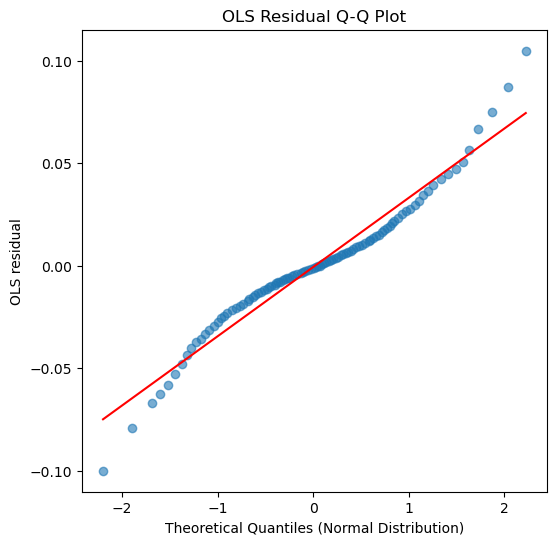

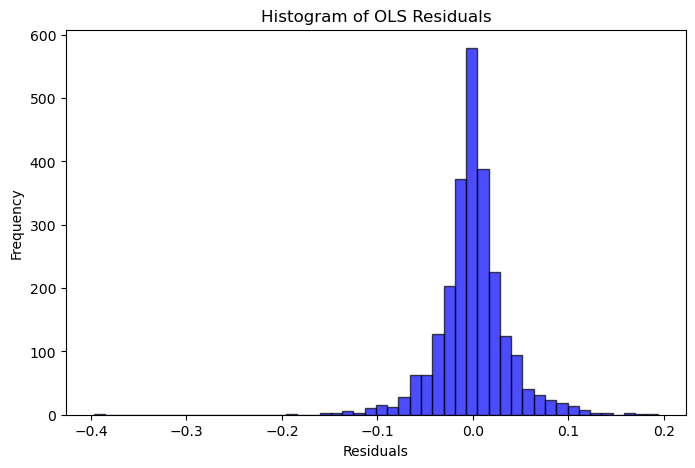

In [3995]:
# Independent, Dependent 분리
y = test_df['returns'].shift(-4).fillna(test_df['returns'].mean())
X = test_df[['target']].fillna(test_df.mean())


# # train, test 데이터 분리
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

start = '2018-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

# X_test['vpin'] = test_df['vpin'].shift(1)

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 10})
# lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())


### OLS Residual의 Q-Q Plot (정규성 확인)

normal_dist = lambda l : np.random.standard_normal(l)

q_count = 100
quantiles = lambda q: np.arange(1/q, 1, 1/q)

residual_q = lr.resid.quantile(quantiles(q_count))

st_nm_dist = pd.Series(normal_dist(len(lr.resid)))
nd_q = st_nm_dist.quantile(quantiles(q_count))

plt.figure(figsize=(6,6))
plt.scatter(nd_q, residual_q, alpha=0.6)

x, y = nd_q, residual_q
lr_params = stats.linregress(x, y)
slope, intercept = lr_params[0], lr_params[1]
lr_model = slope * x + intercept
plt.plot(x, lr_model, color='red')

plt.xlabel('Theoretical Quantiles (Normal Distribution)')
plt.ylabel('OLS residual')
plt.title('OLS Residual Q-Q Plot')
plt.show()

### OLS Residual의 히스토그램 (정규성 확인)
plt.figure(figsize=(8, 5))
plt.hist(lr.resid, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of OLS Residuals")
plt.show()


### Event Flag를 더미변수로 추가하면 기울기가 늘어나는지

=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     41.84
Date:                Sun, 23 Mar 2025   Prob (F-statistic):           1.19e-10
Time:                        09:06:36   Log-Likelihood:                 4695.2
No. Observations:                2465   AIC:                            -9386.
Df Residuals:                    2463   BIC:                            -9375.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
cons

C:\Users\slaye\AppData\Local\Temp\ipykernel_912\884308933.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['event_flag'] = X['event_flag'].shift(-4).fillna(0)
C:\Users\slaye\AppData\Local\Temp\ipykernel_912\884308933.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_event'] = X['target'] * X['event_flag']


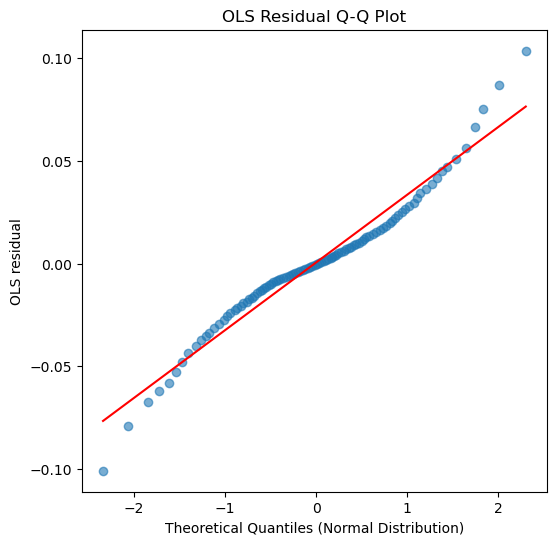

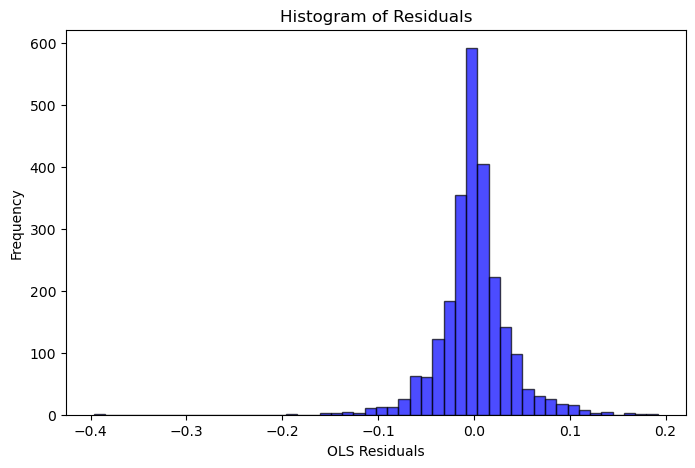

Shapiro-Wilk Test Statistic: 0.9231527680341782, p-value: 9.48876636407248e-34
Jarque-Bera Test Statistic: 7927.079897749783, p-value: 0.0
Residual Variance: 0.0012974442520467544
Residual Standard Deviation: 0.0360200534709036


In [3996]:
# 파생변수 추가
test_df['event_target'] = test_df['target'] * test_df['event_flag'].shift(0).fillna(0)

# Independent, Dependent 분리
y = test_df['returns'].shift(-4).fillna(test_df['returns'].mean())
X = test_df[['target', 'volume', 'event_flag']]
X['event_flag'] = X['event_flag'].shift(-4).fillna(0)
X['target_event'] = X['target'] * X['event_flag']
X = X['target_event'].to_frame()

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

start = '2018-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())



stat, p = shapiro(lr.resid)
print(f"Shapiro-Wilk Test Statistic: {stat}, p-value: {p}")




bp_test = het_breuschpagan(lr.resid, lr.model.exog)
print(f"Breusch-Pagan Test Statistic: {bp_test[0]}, p-value: {bp_test[1]}")



### OLS Residual의 Q-Q Plot (정규성 확인)
normal_dist = lambda l : np.random.standard_normal(l)

q_count = 100
quantiles = lambda q: np.arange(1/q, 1, 1/q)

residual_q = lr.resid.quantile(quantiles(q_count))

st_nm_dist = pd.Series(normal_dist(len(lr.resid)))
nd_q = st_nm_dist.quantile(quantiles(q_count))

plt.figure(figsize=(6,6))
plt.scatter(nd_q, residual_q, alpha=0.6)

x, y = nd_q, residual_q
lr_params = stats.linregress(x, y)
slope, intercept = lr_params[0], lr_params[1]
lr_model = slope * x + intercept
plt.plot(x, lr_model, color='red')

plt.xlabel('Theoretical Quantiles (Normal Distribution)')
plt.ylabel('OLS residual')
plt.title('OLS Residual Q-Q Plot')

plt.show()

### OLS Residual의 히스토그램 (정규성 확인)
plt.figure(figsize=(8, 5))
plt.hist(lr.resid, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("OLS Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()


### 샤피로 테스트 (정규성 검정)
stat, p = shapiro(lr.resid)
print(f"Shapiro-Wilk Test Statistic: {stat}, p-value: {p}")

### jarque bera (왜도, 첨도 검정)
jb_stat, jb_pvalue, _, _ = jarque_bera(lr.resid)
print(f"Jarque-Bera Test Statistic: {jb_stat}, p-value: {jb_pvalue}")

### Variance, Standard Deviation
print(f"Residual Variance: {np.var(lr.resid)}")
print(f"Residual Standard Deviation: {np.std(lr.resid)}")

### XGBoost 학습 (독립변수: Transaction Amount, 종속변수: BTC Returns)

In [3997]:
# Independent, Dependent 분리
y = test_df['returns'].shift(-3).fillna(test_df['returns'].mean())
X = test_df[['target', 'target_returns', 'target_delta', 'volume', 'event_flag']].fillna(test_df.mean())

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

start = '2023-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

X_with_const = sm.add_constant(X_test)


model_xgb = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05, reg_lambda=1, reg_alpha=0.5)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)


# Train MSE vs Test MSE 비교
y_train_pred = model_xgb.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_pred_xgb)

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")


Train MSE: 0.0014422668385327
Test MSE: 0.0006714992503109316


### 과거 변동성이 Target을 잘 설명하는지

In [3998]:
test_df['volatility'] = test_df['returns']**2
test_df['std_5'] = test_df['returns'].rolling(5).std()
test_df['volume_5'] = test_df['volume'].rolling(5).std()

# Independent, Dependent 분리
y = test_df['target']
X = test_df[['volume_5', 'std_5']].fillna(test_df.mean())

# ## train, test 데이터 분리
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle=False)

start = '2018-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())

=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     12.97
Date:                Sun, 23 Mar 2025   Prob (F-statistic):           2.50e-06
Time:                        09:06:37   Log-Likelihood:                -3637.6
No. Observations:                2465   AIC:                             7281.
Df Residuals:                    2462   BIC:                             7299.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const   

### Target의 변화값이 Returns를 유의미하게 설명하는지

In [3999]:
# Independent, Dependent 분리
y = test_df['returns'].shift(-3).fillna(test_df['returns'].mean())
X = test_df[['target_delta', 'rv']].fillna(test_df.mean())

## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

start = '2017-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

# X_test['vpin'] = test_df['vpin'].shift(1).fillna(test_df['vpin'].mean())
# X_test['volume'] = test_df['volume'].shift(1).fillna(test_df['volume'].mean())
# # X_test = X_test['vpin']

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 10})
# lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())

=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                    0.5197
Date:                Sun, 23 Mar 2025   Prob (F-statistic):              0.595
Time:                        09:06:37   Log-Likelihood:                 5388.2
No. Observations:                2830   AIC:                        -1.077e+04
Df Residuals:                    2827   BIC:                        -1.075e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
cons

### Target의 변화율이 Returns를 유의미하게 설명하는지

In [4000]:
# Independent, Dependent 분리
y = test_df['returns'].shift(-3).fillna(test_df['returns'].mean())
X = test_df[['target_returns']].fillna(test_df.mean())

## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

start = '2018-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

# X_test['vpin'] = test_df['vpin'].shift(1).fillna(test_df['vpin'].mean())

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
# lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())

=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     6.311
Date:                Sun, 23 Mar 2025   Prob (F-statistic):             0.0121
Time:                        09:06:37   Log-Likelihood:                 4694.2
No. Observations:                2465   AIC:                            -9384.
Df Residuals:                    2463   BIC:                            -9373.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------


### Target 변화량, 변화율, 값으로 Returns 예측

In [4001]:
# Independent, Dependent 분리
y = test_df['returns'].shift(-3).fillna(test_df['returns'].mean())
X = test_df[['target_returns', 'vpin', 'returns']]
# X['target'] = X['target'].shift(1).fillna(X['target'].mean())
# X['vpin'] = X['vpin']*X['returns']
# X['vpin'] = X['vpin'].shift(1).fillna(X['vpin'].mean())


start = '2018-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

# X_test['vpin'] = test_df['vpin']
# X_test = X_test['vpin']

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 10})
# lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())

=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.867
Date:                Sun, 23 Mar 2025   Prob (F-statistic):            0.00899
Time:                        09:06:37   Log-Likelihood:                 4694.7
No. Observations:                2465   AIC:                            -9381.
Df Residuals:                    2461   BIC:                            -9358.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------


In [4002]:
# Independent, Dependent 분리
y = test_df['returns'].shift(-3).fillna(test_df['returns'].mean())
X = test_df[['target_returns', 'event_flag']]
X['event_flag'] = X['event_flag'].shift(-4).fillna(0)
X['target_event'] = X['target_returns'] * X['event_flag']
X = X['target_event'].to_frame()


start = '2018-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

# X_test['vpin'] = test_df['vpin']
# X_test = X_test['vpin']

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 10})
# lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())

=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.392
Date:                Sun, 23 Mar 2025   Prob (F-statistic):             0.0115
Time:                        09:06:37   Log-Likelihood:                 4692.2
No. Observations:                2465   AIC:                            -9380.
Df Residuals:                    2463   BIC:                            -9369.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
cons

C:\Users\slaye\AppData\Local\Temp\ipykernel_912\1767737699.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['event_flag'] = X['event_flag'].shift(-4).fillna(0)
C:\Users\slaye\AppData\Local\Temp\ipykernel_912\1767737699.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_event'] = X['target_returns'] * X['event_flag']


In [4003]:
# Independent, Dependent 분리
y = test_df['returns'].shift(-3).fillna(test_df['returns'].mean())
X = test_df[['target_returns', 'target', 'vpin', 'event_flag']]
X['event_flag'] = X['event_flag'].shift(-3).fillna(0)
X['target_event'] = X['target'] * X['event_flag']
X['vpin'] = X['vpin'].shift(1).fillna(X['vpin'].mean())
X['target'] = X['target'].shift(1).fillna(X['target'].mean())
X = X[['target', 'target_returns', 'vpin']]

start = '2018-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

# X_test['vpin'] = test_df['vpin']
# X_test = X_test['vpin']

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 10})
# lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())

=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.073
Date:                Sun, 23 Mar 2025   Prob (F-statistic):            0.00167
Time:                        09:06:37   Log-Likelihood:                 4697.9
No. Observations:                2465   AIC:                            -9388.
Df Residuals:                    2461   BIC:                            -9365.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------


C:\Users\slaye\AppData\Local\Temp\ipykernel_912\3882846509.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['event_flag'] = X['event_flag'].shift(-3).fillna(0)
C:\Users\slaye\AppData\Local\Temp\ipykernel_912\3882846509.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_event'] = X['target'] * X['event_flag']
C:\Users\slaye\AppData\Local\Temp\ipykernel_912\3882846509.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

### Event Flag 추가 Target 3종세트 Returns 예측

In [4004]:
# Independent, Dependent 분리
y = test_df['returns'].shift(-3).fillna(test_df['returns'].mean())
X = test_df[['target_returns', 'target', 'event_flag']]
X['event_flag'] = X['event_flag'].shift(-3).fillna(0)
X['target_event'] = X['target'] * X['event_flag']
X = X[['target_event', 'target_returns']]

start = '2024-01-01'
end = '2024-12-31'
X_test = X[(X.index >= start)&(X.index <= end)]
y_test = y[(y.index >= start)&(y.index <= end)]

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 10})
print("=== OLS with Newey-West Standard Errors ===")
print(lr.summary())

=== OLS with Newey-West Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                     4.693
Date:                Sun, 23 Mar 2025   Prob (F-statistic):            0.00992
Time:                        09:06:37   Log-Likelihood:                 590.74
No. Observations:                 274   AIC:                            -1175.
Df Residuals:                     271   BIC:                            -1165.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------


C:\Users\slaye\AppData\Local\Temp\ipykernel_912\1076028199.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['event_flag'] = X['event_flag'].shift(-3).fillna(0)
C:\Users\slaye\AppData\Local\Temp\ipykernel_912\1076028199.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target_event'] = X['target'] * X['event_flag']
